# Calculating Transition Frequencies in ThO

This notebook takes advantage of some code that I wrote that stores molecular constants for molecular states in diatomic molecules and enables calculations of transition frequencies in ThO.

Here, all frequency units are in cm$^{-1}$.

First, import the Molecule and State objects which are defined in `code/molecule.py`. This requires adding the `./code` directory to the system path.

In [1]:
%matplotlib inline
import sys
sys.path.append('./code')

from molecule import State, Molecule
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.xkcd_palette
sns.set_style('white')
sns.set_context("poster")

I saved some ThO data into the path `data/ThO.pkl`. We can load that data and then view that data in a pandas dataframe:

In [2]:
ThO = Molecule.load('data/ThO.pkl')
ThO.to_dataframe()

./code\molecule.py:226: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('T0')


,omega,T0,we,we_xe,Be,D0,alphae,Re
name,,,,,,,,
X,0,0.000,895.77,2.39,[0.33264],1.83e-07,0.0013,1.840
H,1,5316.600,857.20,2.40,[0.32642],1.891e-07,0.00129,1.858
Q,2,6127.921,859.42,2.29,[0.326353],1.919e-07,0.00133,1.856
A,0,10600.820,846.40,2.40,[0.32304],1.87e-07,0.00129,1.867
B,1,11129.140,842.80,2.18,"[0.32364, 0.32497]","[1.88e-07, 1.94e-07]","[0.00129, 0.0013]",1.864
C,1,14490.000,825.10,2.40,"[0.32161, 0.32246]","[1.87e-07, 1.93e-07]","[0.00129, 0.00128]",1.870
E,0,16320.370,829.26,2.30,[0.32309],1.99e-07,0.0013,1.867
G,2,18009.930,809.10,2.30,[0.31814],1.94e-07,0.00128,1.882
F,0,18337.560,757.36,NaN,[0.3214],2.04e-07,None,1.870


Here is an example calculation of a transition frequency. here this is th transition from the absolute ground state (assuming $v=0$) to $|C,J=1; \Omega=e\rangle$ ($\Omega=e$ means the lower of the two omega doublets using the $e$, $f$ notation). To obtain a frequency float in cm$^{-1}$ add the keyword argument `numeric=True`.

In [3]:
print(ThO.transition(name1='X', j1=0, 
                     name2='C', j2=1, omega_doublet2='e'))

print(ThO.transition(name1='X', j1=0, 
                     name2='C', j2=1, omega_doublet2='e', numeric=True)) 

|X, j=0> to |C, j=1; W=e>: 14490.6432193 cm^-1
14490.6432193


Here is an energy level plot of ThO which shows the course grained electronic structure and some of the vibrational structure using lighter colored lines. Those states which are not provided with a vibrational constant do not show vibrational states.

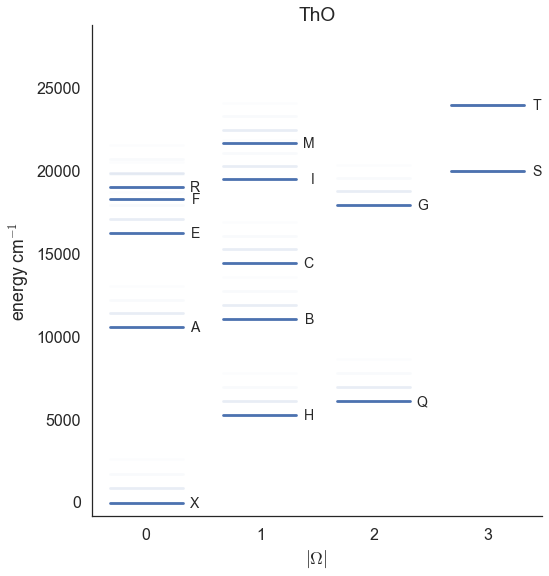

In [4]:
_ = ThO.energy_level_plot()

this function can be customized to produce various types of energy level diagrams

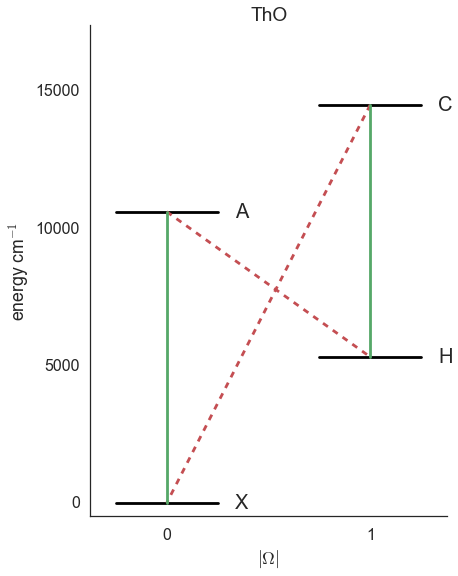

In [11]:
fig = ThO.energy_level_plot(['X','H','C','A'], v=1, color='k',
                            width=.25, aspect_ratio=1.5, font_size=20,
                            transitions=[('X','A'),('H','C')], 
                            decays=[('A','H'),('C','X')])

In [ ]:
    def energy_level_plot(self, states=None, transitions=None, decays=None,
                          v=4, width=.32, show=False, 
                          color=sns.color_palette()[0],
                          transition_color=sns.color_palette()[1],
                          decay_color=sns.color_palette()[2],
                          aspect_ratio = 1.618, font_size=14, **kwargs):
        """
        create an energy level diagram for the molecule
        """
        if states is None:
            states = self.states.keys()
        
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)

        min_e = 0
        max_e = 0
        max_w = 0

        for state in self.states.values():
            if state.name in states:
                for v_i in range(v):
                    eng = state.energy(v=v_i)

                    x = [state.omega - width, state.omega + width]
                    y = [eng, eng]
                    ax.plot(x,y,'-', alpha=1/float(v_i + 1)**3, color=color, **kwargs)

                    if v_i == 0 and not(np.isnan(eng)):

                        min_e = min([min_e, eng])
                        max_e = max([max_e, eng])
                        max_w = max([max_w, state.omega])

                        plt.text(float(state.omega) + width + .15, eng, state.name,
                                va='center', ha='right', size=font_size)
                        
        if decays is None:
            decays = []
        if transitions is None:
            transitions = []
                        
        for decay in decays:
            tstates = [self.states[decay[0]], self.states[decay[1]]]
            x = [tstates[0].omega, tstates[1].omega]
            y = [tstates[0].energy(), tstates[1].energy()]
            ax.plot(x,y,'--',color=decay_color)#,alpha=.5)
        
        for transition in transitions:
            tstates = [self.states[transition[0]], self.states[transition[1]]]
            x = [tstates[0].omega, tstates[1].omega]
            y = [tstates[0].energy(), tstates[1].energy()]
            ax.plot(x,y,'-',color=transition_color)#,alpha=.75)

        y_range = max_e - min_e
        
        ax.set_xlim([-1.5*width, max_w + 1.5*width])
        ax.set_ylim([min_e - y_range/30, max_e + y_range/5])
        ax.set_xticks(list(range(max_w + 1)))

        ax.set_xlabel('$|\Omega|$')
        ax.set_ylabel('energy cm$^{-1}$')
        ax.set_title(self.name)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_aspect(.00009*aspect_ratio)

        if show:
            plt.show()
        return fig

In [ ]:
def energy_level_plot(levels, )

In [ ]:
class EnergyLevelDiagram(object):
    """
    this is a class to generalize the creation of energy level diagrams
    """
    
    def __init__(self, levels=None, couplings=None, emission=None,
                       level_style=None, coupling_style=None, emission_style=None, **kwargs):
        """
        inputs:
        levels (dict with keys equal to the names of the states, and with values
                equal to energy E or a list of form [x position, E position])
        couplings (list of lists of form [state_key_1, state_key_2])
        emission (list of lists of form [state_key_1, state_key_2])
        """

        self.levels    = levels
        self.couplings = couplings
        self.emission  = emission
        
        self.level_style    = level_style
        self.coupling_style = coupling_style
        self.emission_style = emission_style
        
        # dynamically set the width of the levels:
        
        
        self.plot(**kwargs)
        
    def plot(self, width=.32, **kwargs):
        color=sns.color_palette()[0],
                          transition_color=sns.color_palette()[1],
                          decay_color=sns.color_palette()[2],
                          aspect_ratio = 1.618
        